# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# import dataset (which we created in Task 1)
dfPhiladelphiaIncluding0TripsUniqueHours = pd.read_csv("data/exports/dfPhiladelphiaIncluding0TripsUniqueHours.csv.zip")
dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   start_month             8760 non-null   int64  
 1   start_week              8760 non-null   int64  
 2   start_day               8760 non-null   int64  
 3   start_time_hourly       8760 non-null   int64  
 4   min_temp                8760 non-null   float64
 5   max_temp                8760 non-null   float64
 6   isPrecip                8760 non-null   bool   
 7   dayOfWeek               8760 non-null   object 
 8   isWeekend               8760 non-null   bool   
 9   season                  8760 non-null   object 
 10  isHoliday               8760 non-null   bool   
 11  isRushhour              8760 non-null   bool   
 12  numOfRentedBikesHourly  8760 non-null   int64  
dtypes: bool(4), float64(2), int64(5), object(2)
memory usage: 650.3+ KB


In [2]:
dfPhiladelphiaIncluding0TripsUniqueHours

,start_month,start_week,start_day,start_time_hourly,min_temp,max_temp,isPrecip,dayOfWeek,isWeekend,season,isHoliday,isRushhour,numOfRentedBikesHourly
0,1,1,1,0,6.4,6.950,True,Tuesday,False,winter,True,False,2
1,1,1,1,1,6.8,7.075,True,Tuesday,False,winter,True,False,8
2,1,1,1,2,7.2,7.200,True,Tuesday,False,winter,True,False,10
3,1,1,1,3,7.8,8.050,True,Tuesday,False,winter,True,False,7
4,1,1,1,4,8.3,9.400,True,Tuesday,False,winter,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,1,31,19,7.1,7.375,False,Tuesday,False,winter,False,True,44
8756,12,1,31,20,7.8,7.800,False,Tuesday,False,winter,False,False,33
8757,12,1,31,21,8.3,8.300,False,Tuesday,False,winter,False,False,24
8758,12,1,31,22,8.3,8.300,False,Tuesday,False,winter,False,False,26


## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target
- We will justify the selection of features

**!The feature creation process was already done in task 1!**  
This are all features which we created in Task 1:

In [4]:
# Replace values with Integer values
dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'] = dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'].replace(['Monday', 'Tuesday','Wednesday','Thursday',
                                                                                                                       'Friday','Saturday','Sunday'],[0,1,2,3,4,5,6])

# Replace values with Integer values
dfPhiladelphiaIncluding0TripsUniqueHours['season'] = dfPhiladelphiaIncluding0TripsUniqueHours['season'].replace(['summer', 'winter','spring','autumn'],[0,1,2,3])


dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   start_month             8760 non-null   int64  
 1   start_week              8760 non-null   int64  
 2   start_day               8760 non-null   int64  
 3   start_time_hourly       8760 non-null   int64  
 4   min_temp                8760 non-null   float64
 5   max_temp                8760 non-null   float64
 6   isPrecip                8760 non-null   bool   
 7   dayOfWeek               8760 non-null   int64  
 8   isWeekend               8760 non-null   bool   
 9   season                  8760 non-null   int64  
 10  isHoliday               8760 non-null   bool   
 11  isRushhour              8760 non-null   bool   
 12  numOfRentedBikesHourly  8760 non-null   int64  
dtypes: bool(4), float64(2), int64(7)
memory usage: 650.3 KB


### 4.1.1 Dummy Feature Creation (maybe after evaluation)
- We already created all features we need in Task 1, but we need to change some features into dummy variables to assure predictive performance

In [5]:
# here just 2 blocks of code

### 4.1.2 Justify the selection of features 

We definitely need:
- 'numOfRentedBikesHourly', because this is our target value
- 'start_time_hourly', because we want to predict the demand in the next hour (so this is like "the" main input)

We will test/evaluate if we need the following features:
- 'start_month', 'start_week' & 'start_day'
- 'min_temp' & 'max_temp'
- 'isPrecip'
- 'dayOfWeek'
- 'isWeekend'
- 'season'
- 'isHoliday'
- 'isRushhour'

In [6]:
# Variance criteria or correlation criteria or filtering or embedded methods
# we will take variance & correlations

#### Variance:

In [7]:
dfPhiladelphiaIncluding0TripsUniqueHours[['min_temp', 'max_temp']].var()

min_temp    103.864476
max_temp    104.211228
dtype: float64

In [8]:
#### take out features which will become dummys
#### season and so on missing, but we do know the variance because, we defined it
dfPhiladelphiaIncluding0TripsUniqueHours[['start_month', 'start_week', 'start_day', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'season', 'isHoliday', 'isRushhour', 'start_time_hourly', 'numOfRentedBikesHourly']].var()

start_month                 11.889036
start_week                 226.435352
start_day                   77.382795
min_temp                   103.864476
max_temp                   104.211228
isPrecip                     0.078957
dayOfWeek                    4.000427
isWeekend                    0.203769
season                       1.258271
isHoliday                    0.026650
isRushhour                   0.206621
start_time_hourly           47.922137
numOfRentedBikesHourly    4310.690580
dtype: float64

In [9]:
# min_temp & max_temp same variance => validate if they have different values

#### Correlations

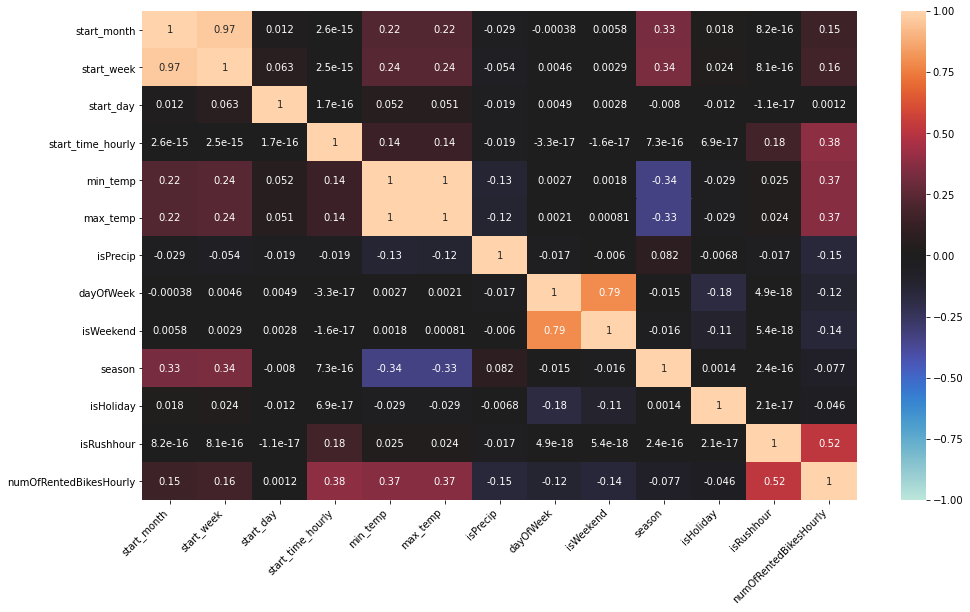

In [10]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = dfPhiladelphiaIncluding0TripsUniqueHours.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

#### Feature selection:
We will drop `max_temp` or `min_temp`, because they are perfectly correlated.  
We will also drop `start_week`, because it has a very high correlation with start_month & we know from domain knowledge that if we take start_month & start_day as inputs for our models the feature start_week is very likely to add no additional value.

In [11]:
dfPhiladelphiaIncluding0TripsUniqueHours.drop(columns = ['min_temp', 'start_week'], inplace = True)
dfPhiladelphiaIncluding0TripsUniqueHours

,start_month,start_day,start_time_hourly,max_temp,isPrecip,dayOfWeek,isWeekend,season,isHoliday,isRushhour,numOfRentedBikesHourly
0,1,1,0,6.950,True,1,False,1,True,False,2
1,1,1,1,7.075,True,1,False,1,True,False,8
2,1,1,2,7.200,True,1,False,1,True,False,10
3,1,1,3,8.050,True,1,False,1,True,False,7
4,1,1,4,9.400,True,1,False,1,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,7.375,False,1,False,1,False,True,44
8756,12,31,20,7.800,False,1,False,1,False,False,33
8757,12,31,21,8.300,False,1,False,1,False,False,24
8758,12,31,22,8.300,False,1,False,1,False,False,26


### 4.1.3 (Visualisation of dependencies)

## 4.2 Model Building & Evaluation

In [12]:
# function for normalize numeric and encode categorical features and for create pipeline

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [13]:
# defining categorical and numeric features of dfPhiladelphiaIncluding0TripsUniqueHours

categoric = ['start_month', 'start_day','start_time_hourly','isPrecip','dayOfWeek','isWeekend','season',
             'isHoliday','isRushhour']
numeric = ['max_temp']

In [14]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/dfPhiladelphiaIncluding0TripsUniqueHours["numOfRentedBikesHourly"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [15]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

In [16]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [17]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphiaIncluding0TripsUniqueHours.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphiaIncluding0TripsUniqueHours['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val = x_train
y_train_val = y_train

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model
- x_train_val, y_train_val &rarr; 70% input features for training the model

### 4.2.1 Lasso Regression

Using Lasso Regression to predict the `numOfRentedBikesHourly`.

In [18]:
# creating the regression model

lasso_reg = Lasso()

**Looking for the best Hyperparameters**

In [19]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__alpha': loguniform(1e-2, 1e2),
              'model__tol' : loguniform(1e-5,1e0)
             }

In [20]:
pipeline = pipeline_for_prediction(categoric, numeric, lasso_reg)

In [21]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 1/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1224.608 total time=   0.0s
[CV 2/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 2/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1492.931 total time=   0.0s
[CV 3/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 3/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1208.652 total time=   0.0s
[CV 4/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 4/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1611.100 total time=   0.0s
[CV 5/15; 1/50] START model__alpha=0.314891164795686, model

C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



[CV 8/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1399.007 total time=   0.0s
[CV 9/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 9/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1520.075 total time=   0.0s
[CV 10/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 10/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1455.573 total time=   0.0s
[CV 11/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 11/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1236.521 total time=   0.0s
[CV 12/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 12/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1337.102 total time=   0.0s
[CV 13/15; 1/50] START model__alpha=0.314891164795686, model__

[CV 8/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 8/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1392.319 total time=   0.0s
[CV 9/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 9/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1448.751 total time=   0.0s
[CV 10/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 10/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1371.647 total time=   0.0s
[CV 11/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 11/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1252.601 total time=   0.0s
[CV 12/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 12/15; 4/50] END model__alpha=0.017073967431528118, model__

[CV 7/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 7/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4311.179 total time=   0.0s
[CV 8/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 8/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4243.699 total time=   0.0s
[CV 9/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 9/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4633.845 total time=   0.0s
[CV 10/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 10/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4337.906 total time=   0.0s
[CV 11/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 11/15; 7/50] END model__alpha=21.368329072358737, mo

[CV 5/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 5/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1527.179 total time=   0.0s
[CV 6/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 6/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1430.848 total time=   0.0s
[CV 7/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 7/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1470.192 total time=   0.0s
[CV 8/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 8/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1487.580 total time=   0.0s
[CV 9/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 9/15; 10/50] END model__alpha=0.53429372612797

[CV 1/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 1/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1488.036 total time=   0.0s
[CV 2/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 2/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1728.936 total time=   0.0s
[CV 3/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 3/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1446.118 total time=   0.0s
[CV 4/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 4/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1832.470 total time=   0.0s
[CV 5/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 5/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.0843101393

[CV 1/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 1/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2532.253 total time=   0.0s
[CV 2/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 2/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2614.960 total time=   0.0s
[CV 3/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 3/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2469.130 total time=   0.0s
[CV 4/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 4/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2859.371 total time=   0.0s
[CV 5/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 5/15; 16/50] END model__alpha=2.6926469100861774, model

[CV 11/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 11/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-3992.944 total time=   0.0s
[CV 12/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 12/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4397.374 total time=   0.0s
[CV 13/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 13/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4279.768 total time=   0.0s
[CV 14/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 14/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4736.894 total time=   0.0s
[CV 15/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 15/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.1101505679

[CV 5/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1294.552 total time=   0.0s
[CV 6/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 6/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1297.155 total time=   0.0s
[CV 7/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 7/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1258.302 total time=   0.0s
[CV 8/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 8/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1371.515 total time=   0.0s
[CV 9/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 9/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1430.333 total time=   0.0s
[CV 10

[CV 2/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1480.111 total time=   0.0s
[CV 3/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 3/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1158.550 total time=   0.0s
[CV 4/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 4/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1594.389 total time=   0.0s
[CV 5/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 5/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1329.925 total time=   0.0s
[CV 6/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 6/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1283.236 total time=   0.0s
[CV 7/15; 24/50] START m

[CV 1/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-3992.944 total time=   0.0s
[CV 2/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 2/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4397.374 total time=   0.0s
[CV 3/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 3/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4279.768 total time=   0.0s
[CV 4/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 4/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4736.894 total time=   0.0s
[CV 5/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 5/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4448.105 total time=   0.0s
[CV 6/15; 27/50] START model__alpha=57.279

[CV 10/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1374.654 total time=   0.1s
[CV 11/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 11/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1227.098 total time=   0.1s
[CV 12/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 12/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1272.807 total time=   0.0s
[CV 13/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 13/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1147.111 total time=   0.0s
[CV 14/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 14/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1552.111 total time=   0.

[CV 4/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 4/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4611.132 total time=   0.0s
[CV 5/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 5/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4318.205 total time=   0.0s
[CV 6/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 6/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-3869.168 total time=   0.0s
[CV 7/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 7/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4281.038 total time=   0.0s
[CV 8/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 8/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.0

[CV 13/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 13/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1145.612 total time=   0.0s
[CV 14/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 14/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1531.178 total time=   0.0s
[CV 15/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 15/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1494.679 total time=   0.0s
[CV 1/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 1/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1207.207 total time=   0.0s
[CV 2/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 2/15; 35/50] END model__alpha=0.01987021538542862, model__tol

[CV 10/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 10/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1366.462 total time=   0.0s
[CV 11/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 11/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1233.963 total time=   0.0s
[CV 12/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 12/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1273.284 total time=   0.0s
[CV 13/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 13/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1150.911 total time=   0.0s
[CV 14/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 14/15; 37/50] END model__alpha=0.0105217618684

[CV 6/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 6/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1303.125 total time=   0.0s
[CV 7/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 7/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1295.564 total time=   0.0s
[CV 8/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 8/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1381.813 total time=   0.0s
[CV 9/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 9/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1498.505 total time=   0.0s
[CV 10/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 10/15; 40/50] END model__alpha=0.271558195528

[CV 1/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 1/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1229.268 total time=   0.0s
[CV 2/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 2/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1480.930 total time=   0.0s
[CV 3/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 3/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1159.783 total time=   0.0s
[CV 4/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 4/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1596.448 total time=   0.0s
[CV 5/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 5/15; 43/50] END model__alpha=0.17535

[CV 1/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 1/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1224.207 total time=   0.0s
[CV 2/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 2/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1469.373 total time=   0.0s
[CV 3/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 3/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1148.534 total time=   0.0s
[CV 4/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 4/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1599.749 total time=   0.0s
[CV 5/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 5/15; 46/50] END model__alpha=0.030086868214458433, mod

[CV 12/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 12/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3472.069 total time=   0.0s
[CV 13/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 13/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3399.954 total time=   0.0s
[CV 14/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 14/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3773.954 total time=   0.0s
[CV 15/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 15/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3623.004 total time=   0.0s
[CV 1/15; 49/50] START model__alpha=1.2329098365270508, model__tol=0.0013731092468240286
[CV 1/15; 49/50] END model__alpha=1.232909836527050

**Training & Evaluation of the model with the best hyperparameters**

In [22]:
lasso_reg_end = Lasso(alpha=0.10842262717330158, tol = 0.020540519425388454)

In [23]:
pipeline_end = pipeline_fit_predict(lasso_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  26.667
MSE:  1365.054
RMSE:  36.947
Accuracy: 60.35 %
R2:  69.394 %
Max Residual Error:  182.335


### 4.2.1 Random Forest Regression

Using Random Forest Regression to predict the `numOfRentedBikesHourly`.

In [24]:
# creating the regression model

forest_reg = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", random_state=42) 

**Looking for the best Hyperparameters**

In [25]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [26]:
pipeline = pipeline_for_prediction(categoric, numeric, forest_reg)

In [27]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10, n_jobs=4)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits


C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best neg_mean_squared_error Score was: -748.9208534408897
The best hyper parameters for the model are:
{'model__ccp_alpha': 0.00028150941749886896, 'model__max_depth': 20}


**Training & Evaluation of the model with the best hyperparameters**

In [28]:
forest_reg_end = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", ccp_alpha = 0.005938952698993865,
                                       max_depth = 26)

In [29]:
pipeline_end = pipeline_fit_predict(forest_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  13.513
MSE:  548.070
RMSE:  23.411
Accuracy: 79.91 %
R2:  87.712 %
Max Residual Error:  264.753


### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**Feature engineering**

We won't use the pipeline for the ANN, so we will shortly create dummy variables and split the data and normalize it

In [30]:
# Prepare variables for dummy creation
dfPhiladelphiaIncluding0TripsUniqueHours['start_month'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_month'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['start_day'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_day'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['start_time_hourly'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_time_hourly'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'] = dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['season'] = dfPhiladelphiaIncluding0TripsUniqueHours['season'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
dfPhiladelphiaIncluding0TripsUniqueHours = pd.get_dummies(dfPhiladelphiaIncluding0TripsUniqueHours)
dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   max_temp                8760 non-null   float64
 1   isPrecip                8760 non-null   bool   
 2   isWeekend               8760 non-null   bool   
 3   isHoliday               8760 non-null   bool   
 4   isRushhour              8760 non-null   bool   
 5   numOfRentedBikesHourly  8760 non-null   int64  
 6   start_month_1           8760 non-null   uint8  
 7   start_month_10          8760 non-null   uint8  
 8   start_month_11          8760 non-null   uint8  
 9   start_month_12          8760 non-null   uint8  
 10  start_month_2           8760 non-null   uint8  
 11  start_month_3           8760 non-null   uint8  
 12  start_month_4           8760 non-null   uint8  
 13  start_month_5           8760 non-null   uint8  
 14  start_month_6           8760 non-null   

In [31]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphiaIncluding0TripsUniqueHours.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphiaIncluding0TripsUniqueHours['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

In [32]:
# Normalizing training data

st_scaler = StandardScaler()
st_scaler.fit(x_train)
x_train = st_scaler.transform(x_train)

st_scaler = StandardScaler()
st_scaler.fit(x_val)
x_val = st_scaler.transform(x_val)

**Building the model with the functional API of Keras:**

In [33]:
#pip install tensorflow

In [34]:
# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers

In [35]:
###### INTEGRATE HYPERPARAMTERTUNING TIPPS!
###### RELU IN EACH LAYER?

def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(83,)) # shapesize dependent of input features
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') # MAYBE TRY DIFFERENT OPTIMIZER
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [36]:
#pip install keras-tuner

In [37]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hyperparametertuning:

- We choose the HyperBand Tuner from Keras

In [38]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    #directory = os.path.normpath('C:/#######')
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': None}


To clear the training outputs after each training step define a callback:

In [40]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [41]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 07s]
val_loss: 490.35150146484375

Best val_loss So Far: 459.9944152832031
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [42]:
tuner.results_summary()

Results summary
Results in .\kerastuner_LOG
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 6
hidden_layers_2_units: 128
hidden_layers_3_units: 96
hidden_layers_4_units: 160
hidden_layers_5_units: 224
hidden_layers_6_units: 128
hidden_layers_7_units: 256
hidden_layers_8_units: 256
hidden_layers_9_units: 128
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 459.9944152832031
Trial summary
Hyperparameters:
hidden_layer_1_units: 192
total_added_hidden_layers: 4
hidden_layers_2_units: 160
hidden_layers_3_units: 96
hidden_layers_4_units: 64
hidden_layers_5_units: 192
hidden_layers_6_units: 96
hidden_layers_7_units: 160
hidden_layers_8_units: 128
hidden_layers_9_units: 32
hidden_layers_10_units: 160
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 490.35150146484375
Trial summary
Hyperparameters:
hidden_layer_1_units: 160
total_added_hidden_layers: 4
hidden_layers_2_units: 96

Get optimal hyperparameters:

In [43]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 224 
and the total number of hidden layers is 7.



Get the best model:

In [44]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show a summary of the model:

In [45]:
model_ann.summary()

Model: "system_level_bike_rental_demand_philadelphia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense (Dense)               (None, 224)               18816     
                                                                 
 dense_1 (Dense)             (None, 128)               28800     
                                                                 
 dense_2 (Dense)             (None, 96)                12384     
                                                                 
 dense_3 (Dense)             (None, 160)               15520     
                                                                 
 dense_4 (Dense)             (None, 224)               36064     
                                                                 
 dense_5 (Dense)      

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz`and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [46]:
#pip install pydot

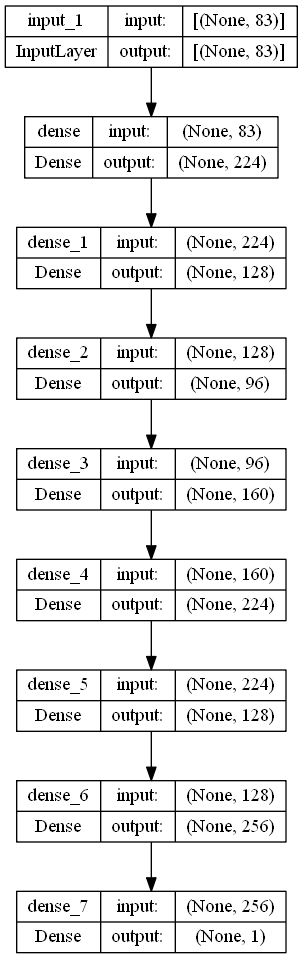

In [47]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

In hyperparameter tuning the model was only trained with 20 epochs because of the performance. So now we continue the training to get a optimal result.

Define a callback which stops earlier when their is no further improvement and which avoids overfitting by monitoring the val_loss:

In [48]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100, 
    restore_best_weights=True 
    )

In [49]:
model_ann.fit(x_train, y_train, epochs=1000, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/1000
137/137 [==============================] - 1s 4ms/step - loss: 104.6569 - val_loss: 490.7559
Epoch 2/1000
137/137 [==============================] - 0s 3ms/step - loss: 89.7629 - val_loss: 467.9890
Epoch 3/1000
137/137 [==============================] - 0s 3ms/step - loss: 76.8827 - val_loss: 508.0971
Epoch 4/1000
137/137 [==============================] - 0s 3ms/step - loss: 68.7355 - val_loss: 476.3253
Epoch 5/1000
137/137 [==============================] - 0s 3ms/step - loss: 61.8840 - val_loss: 501.4254
Epoch 6/1000
137/137 [==============================] - 0s 3ms/step - loss: 53.8278 - val_loss: 529.5734
Epoch 7/1000
137/137 [==============================] - 0s 3ms/step - loss: 47.2937 - val_loss: 508.9454
Epoch 8/1000
137/137 [==============================] - 0s 3ms/step - loss: 51.1630 - val_loss: 485.8946
Epoch 9/1000
137/137 [==============================] - 0s 3ms/step - loss: 34.3466 - val_loss: 491.8384
Epoch 10/1000
137/137 [==============================]

137/137 [==============================] - 0s 3ms/step - loss: 8.0739 - val_loss: 444.1966
Epoch 79/1000
137/137 [==============================] - 0s 3ms/step - loss: 7.6538 - val_loss: 444.5996
Epoch 80/1000
137/137 [==============================] - 0s 3ms/step - loss: 6.8180 - val_loss: 448.6659
Epoch 81/1000
137/137 [==============================] - 0s 3ms/step - loss: 7.3733 - val_loss: 440.3635
Epoch 82/1000
137/137 [==============================] - 0s 3ms/step - loss: 12.6835 - val_loss: 439.3359
Epoch 83/1000
137/137 [==============================] - 0s 3ms/step - loss: 9.3292 - val_loss: 443.3031
Epoch 84/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.6966 - val_loss: 435.2869
Epoch 85/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.6113 - val_loss: 451.9199
Epoch 86/1000
137/137 [==============================] - 0s 3ms/step - loss: 6.5958 - val_loss: 445.5316
Epoch 87/1000
137/137 [==============================] - 0s 3ms/step

137/137 [==============================] - 0s 3ms/step - loss: 2.9660 - val_loss: 427.0437
Epoch 156/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.0930 - val_loss: 444.2222
Epoch 157/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.9831 - val_loss: 431.9305
Epoch 158/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.2376 - val_loss: 427.1105
Epoch 159/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.2069 - val_loss: 427.0068
Epoch 160/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.0433 - val_loss: 435.2004
Epoch 161/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.2013 - val_loss: 423.5161
Epoch 162/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.5432 - val_loss: 424.1420
Epoch 163/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.2034 - val_loss: 435.5216
Epoch 164/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 4.3664 - val_loss: 421.7450
Epoch 233/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.3957 - val_loss: 421.2400
Epoch 234/1000
137/137 [==============================] - 0s 3ms/step - loss: 6.1348 - val_loss: 428.2710
Epoch 235/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.4562 - val_loss: 415.4636
Epoch 236/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.0227 - val_loss: 422.2445
Epoch 237/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.4546 - val_loss: 416.8400
Epoch 238/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.6041 - val_loss: 416.5992
Epoch 239/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.1129 - val_loss: 421.1534
Epoch 240/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.6411 - val_loss: 425.0296
Epoch 241/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 4.2262 - val_loss: 427.5768
Epoch 310/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.0385 - val_loss: 412.0103
Epoch 311/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.4127 - val_loss: 413.5356
Epoch 312/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.1995 - val_loss: 415.2584
Epoch 313/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.2221 - val_loss: 411.4247
Epoch 314/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.4588 - val_loss: 414.3911
Epoch 315/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.1405 - val_loss: 416.8674
Epoch 316/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.1628 - val_loss: 417.4016
Epoch 317/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.5390 - val_loss: 418.6148
Epoch 318/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 2.0498 - val_loss: 406.6857
Epoch 387/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.5186 - val_loss: 403.4689
Epoch 388/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.2007 - val_loss: 409.1416
Epoch 389/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.4451 - val_loss: 408.8568
Epoch 390/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.1762 - val_loss: 413.8257
Epoch 391/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.3081 - val_loss: 405.8278
Epoch 392/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.1258 - val_loss: 406.8754
Epoch 393/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.8263 - val_loss: 407.2875
Epoch 394/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.4831 - val_loss: 408.4917
Epoch 395/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 3.2771 - val_loss: 401.4091
Epoch 464/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.5229 - val_loss: 404.3613
Epoch 465/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6183 - val_loss: 401.7656
Epoch 466/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6462 - val_loss: 403.6315
Epoch 467/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.8849 - val_loss: 406.5186
Epoch 468/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.0682 - val_loss: 406.4308
Epoch 469/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.8652 - val_loss: 406.9350
Epoch 470/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.3774 - val_loss: 404.0156
Epoch 471/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.2109 - val_loss: 401.2344
Epoch 472/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 2.6640 - val_loss: 403.6174
Epoch 541/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.7079 - val_loss: 407.3059
Epoch 542/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.5453 - val_loss: 397.2660
Epoch 543/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.7895 - val_loss: 401.6993
Epoch 544/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.5628 - val_loss: 401.0010
Epoch 545/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.2681 - val_loss: 402.3300
Epoch 546/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.7668 - val_loss: 401.4481
Epoch 547/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.4626 - val_loss: 402.4895
Epoch 548/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.4837 - val_loss: 400.0777
Epoch 549/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 1.7895 - val_loss: 396.9734
Epoch 618/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.9246 - val_loss: 395.2916
Epoch 619/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.8196 - val_loss: 400.2421
Epoch 620/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.5996 - val_loss: 397.4653
Epoch 621/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.4812 - val_loss: 398.0797
Epoch 622/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.8203 - val_loss: 398.0250
Epoch 623/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.0022 - val_loss: 400.1917
Epoch 624/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.8428 - val_loss: 398.7990
Epoch 625/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.7770 - val_loss: 399.6895
Epoch 626/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 1.3010 - val_loss: 397.7347
Epoch 695/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6456 - val_loss: 399.1147
Epoch 696/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.3176 - val_loss: 396.3094
Epoch 697/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6836 - val_loss: 398.6543
Epoch 698/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6858 - val_loss: 398.5275
Epoch 699/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.2534 - val_loss: 397.7878
Epoch 700/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.7514 - val_loss: 395.8028
Epoch 701/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.9468 - val_loss: 399.5562
Epoch 702/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.8847 - val_loss: 396.7355
Epoch 703/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 1.8124 - val_loss: 394.6965
Epoch 772/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.0321 - val_loss: 393.9286
Epoch 773/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.2166 - val_loss: 395.5567
Epoch 774/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.2433 - val_loss: 395.5314
Epoch 775/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.6053 - val_loss: 395.4996
Epoch 776/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.3027 - val_loss: 396.8420
Epoch 777/1000
137/137 [==============================] - 0s 3ms/step - loss: 2.1542 - val_loss: 395.1434
Epoch 778/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.8644 - val_loss: 395.5325
Epoch 779/1000
137/137 [==============================] - 0s 3ms/step - loss: 1.3694 - val_loss: 392.0423
Epoch 780/1000
137/137 [==============================] - 0s 

**Evaluation of the performance of the model:**

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [51]:
st_scaler = StandardScaler()
st_scaler.fit(x_test)
x_test = st_scaler.transform(x_test)

In [53]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphiaIncluding0TripsUniqueHours["numOfRentedBikesHourly"].mean()))*100,2), "%")

83/83 [==============================] - 0s 1ms/step
MAE: 12.034332605790421
RMSE: 20.716272411528173
Accuracy: 82.11 %
